# Set Up

## Importing Libraries

In [249]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

## Extra

# Data Collection/Preprocessing

## Collecting Data

In [250]:
data = pd.read_csv("../outputs/training_metadata.csv")

In [251]:
data.head()

,path,left,right,forward,backward,brake
0,outputs/training_data/1.jpeg,1,0,1,0,0
1,outputs/training_data/vertically_flipped_1.jpeg,1,0,1,0,0
2,outputs/training_data/horizontally_flipped_1.jpeg,1,0,1,0,0
3,outputs/training_data/2.jpeg,1,0,1,0,0
4,outputs/training_data/vertically_flipped_2.jpeg,1,0,1,0,0


## Analyzing Data

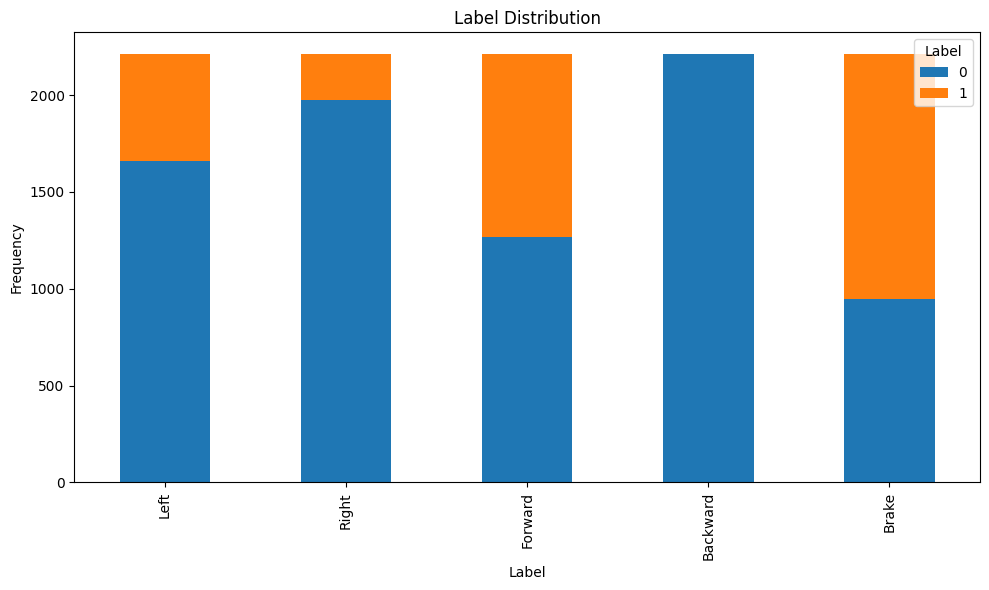

In [252]:
left_labels = data['left']
right_labels = data['right']
forward_labels = data['forward']
backward_labels = data['backward']
brake_labels = data['brake']

left_counts = left_labels.value_counts()
right_counts = right_labels.value_counts()
forward_counts = forward_labels.value_counts()
backward_counts = backward_labels.value_counts()
brake_counts = brake_labels.value_counts()

df = pd.DataFrame({
    'Left': left_counts,
    'Right': right_counts,
    'Forward': forward_counts,
    'Backward': backward_counts,
    'Brake': brake_counts
}).transpose()

# Plot the distribution of labels
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.legend(['0', '1'], title='Label')

plt.tight_layout()
plt.show()

## Preprocessing Data

In [253]:
def load_image(image_path):
    image = Image.open("../"+image_path)
    image = np.array(image)
    return image

In [254]:
data['path'][0]

'outputs/training_data/1.jpeg'

In [255]:
images = [load_image(image_path) for image_path in data['path']]
images = np.array(images)

In [256]:
targets = data[['left', 'right', 'forward', 'backward', 'brake']].values

## Splitting Data

In [257]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [258]:
sample_image_path = "../outputs/training_data/1.jpeg"
sample_image = Image.open(sample_image_path)
image_width, image_height = sample_image.size
num_channels = len(sample_image.getbands())

# Neural Network

## Model Set Up

In [259]:
optimizer = Adam(learning_rate=0.001)

In [260]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(
        image_height, image_width, num_channels)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.Flatten(),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.75),
    layers.Dense(5, activation='sigmoid')
])

## Training Model

In [261]:
model.compile(optimizer=optimizer, loss='mae')

In [262]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10


56/56 [==============================] - 5s 83ms/step - loss: 0.4699 - val_loss: 0.3868
Epoch 2/10
56/56 [==============================] - 5s 81ms/step - loss: 0.4275 - val_loss: 0.3624
Epoch 3/10
56/56 [==============================] - 5s 89ms/step - loss: 0.4137 - val_loss: 0.3717
Epoch 4/10
56/56 [==============================] - 5s 83ms/step - loss: 0.4178 - val_loss: 0.3620
Epoch 5/10
56/56 [==============================] - 5s 81ms/step - loss: 0.3938 - val_loss: 0.3505
Epoch 6/10
56/56 [==============================] - 5s 81ms/step - loss: 0.3864 - val_loss: 0.3423
Epoch 7/10
56/56 [==============================] - 5s 81ms/step - loss: 0.3825 - val_loss: 0.3638
Epoch 8/10
56/56 [==============================] - 5s 82ms/step - loss: 0.3913 - val_loss: 0.3589
Epoch 9/10
56/56 [==============================] - 5s 81ms/step - loss: 0.4051 - val_loss: 0.3310
Epoch 10/10
56/56 [==============================] - 5s 83ms/step - loss: 0.3813 - val_loss: 0.3279


## Testing Model

In [263]:
test_loss = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 23ms/step - loss: 0.3032


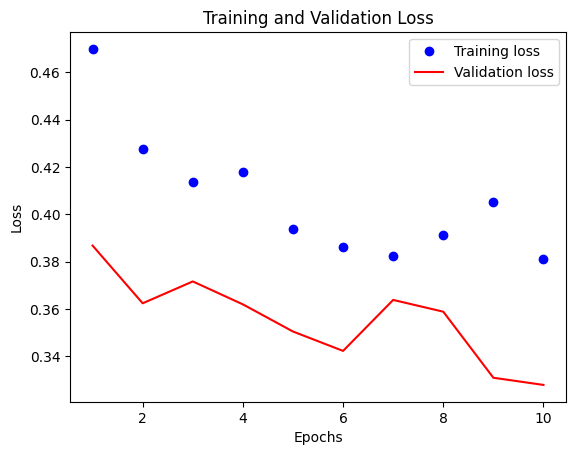

In [264]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [265]:
image = X_test[5]

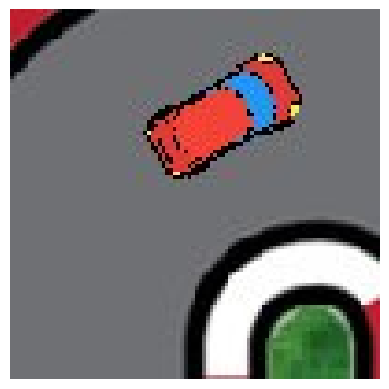

In [266]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [267]:
test_image = image.reshape(1, image_height, image_width, num_channels)

In [268]:
predictions = model.predict(test_image)

1/1 [==============================] - 0s 38ms/step


In [269]:
print(predictions)

[[0. 0. 1. 0. 1.]]


## Saving Model Weights

In [270]:
model.save("../models/CNN_steering_model.h5")

/Users/andrew/Desktop/Projects/SelfDrivingCarSimulator/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
